# Notebook to format data from "Machine learning enables improved runtime and precision for bio-loggers on seabirds", Korpela et al (2020).

Data was shared by Takuya Maekawa over email.

[Paper](https://www.nature.com/articles/s42003-020-01356-8)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal
import datetime
import tqdm

In [3]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/maekawa_gulls'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/maekawa_gulls'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
data_fp = os.path.join(raw_data_dir, 'raw_data.csv')
annotations_fp = os.path.join(raw_data_dir, 'labels.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [4]:
# Dataset metadata
dataset_metadata = {}
sr = 25
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'maekawa_gulls'

In [5]:
# Load data and annotations

data = pd.read_csv(data_fp)
annotations = pd.read_csv(annotations_fp)

data['datetime'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
annotations['stt_datetime'] = pd.to_datetime(annotations['stt_timestamp'], infer_datetime_format=True)
annotations['stp_datetime'] = pd.to_datetime(annotations['stp_timestamp'], infer_datetime_format=True)

In [6]:
# Specify individuals

individuals = sorted([int(x) for x in data['logger_id'].unique()])
data['individual_id'] = data['logger_id']

animal_tag_to_ind_id = {}
for tag in data['animal_tag'].unique():
    data_sub = data[data['animal_tag'] == tag]
    assert len(data_sub['individual_id'].unique()) == 1
    ind_id = data_sub['individual_id'].unique()[0]
    animal_tag_to_ind_id[tag] = ind_id
    
annotations['individual_id'] = annotations['animal_tag'].map(lambda x : animal_tag_to_ind_id[x])

In [7]:
# Specify behavior labels

beh_names = ['unknown', 
             'flying',
             'foraging',
             'stationary']

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

In [8]:
# Populate data df with annotations

data['beh_label'] = 0

for individual in tqdm.tqdm(individuals):
    annotations_sub = annotations[annotations['individual_id'] == individual]
    for i, row in annotations_sub.iterrows():
        start = row['stt_datetime']
        end = row['stp_datetime']
        label = beh_str_to_int[row['activity']]
        data.loc[(data['individual_id'] == individual)&(data['datetime'] >= start) & (data['datetime'] <= end), 'beh_label'] = label

100%|██████████| 11/11 [00:21<00:00,  1.99s/it]


In [9]:
# Omit a section with anomolies

data = pd.concat([data.iloc[:718350], data.iloc[1268350:]]).reset_index().copy()

# Split into clips where there are time gaps

data['diff'] = data['datetime'].diff().dt.total_seconds()
data['diff'] = (data['diff'] != 0.04)
current_clip_id = -1
clip_id_to_individual_id = {}
data['clip_id'] = 0
for index in tqdm.tqdm(data['diff'][data['diff']].index):
    current_clip_id += data.loc[index, 'diff']
    clip_id_to_individual_id['clip_' + str(current_clip_id)] = int(data.loc[index, 'individual_id'])
    data.loc[index:, 'clip_id'] = current_clip_id
    
## check that each clip is associated with a unique individual

for i in data['clip_id'].unique():
    assert len(data[data['clip_id'] == i]['individual_id'].unique()) == 1
    
print("Each clip is associated with a unique individual")

## convention is that clip id's are strings
    
data['clip_id'] = data['clip_id'].map(lambda x : "clip_" + str(x))

100%|██████████| 174/174 [00:11<00:00, 15.62it/s]


Each clip is associated with a unique individual


In [10]:
# Omit short clips (fewer than 120 seconds)

long_clips = list(data['clip_id'].value_counts()[data['clip_id'].value_counts() >= 120 * sr].keys())
data = data[data['clip_id'].isin(long_clips)].copy()

# Omit clip 23 and 173, because of data anomalies

data = data[~data['clip_id'].isin(['clip_23', 'clip_173'])].copy()

# Recreate list of individuals, just in case any were dropped in this process

individuals = sorted([int(x) for x in data['individual_id'].unique()])
clip_ids = sorted([x for x in data['clip_id'].unique()])

tocheck = list(clip_id_to_individual_id)
for k in tocheck:
    if k not in clip_ids:
        clip_id_to_individual_id.pop(k)

In [11]:
## Save clip ids

dataset_metadata['clip_ids'] = clip_ids
dataset_metadata['individual_ids'] = individuals
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [12]:
# Set up data splits: divide individuals across folds for cross validation

n_folds = 5
dataset_metadata['n_folds'] = n_folds
individuals_per_fold = {i : [] for i in range(n_folds)}

for pointer, individual in enumerate(individuals):
    individuals_per_fold[pointer % n_folds].append(individual)
    
# switch manually to ensure fold 0 has all classes represented
individuals_per_fold[0] = [1, 9, 10]
individuals_per_fold[1] = [2, 6]
individuals_per_fold[2] = [3, 11]
individuals_per_fold[3] = [4, 8]
individuals_per_fold[4] = [5, 7]
    
dataset_metadata['individuals_per_fold'] = individuals_per_fold
    
print(individuals_per_fold)
print("There are %d individuals" % len(individuals))

{0: [1, 9, 10], 1: [2, 6], 2: [3, 11], 3: [4, 8], 4: [5, 7]}
There are 11 individuals


In [13]:
# Set up clip ids 

clip_ids_per_fold = {i : [] for i in range(n_folds)}
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    for fold in range(n_folds):
        if individual in individuals_per_fold[fold]:
            clip_ids_per_fold[fold].append(clip_id)
for fold in range(n_folds):
    clip_ids_per_fold[fold] = sorted(clip_ids_per_fold[fold])

dataset_metadata['clip_ids_per_fold'] = clip_ids_per_fold

In [14]:
print("There are %d individuals" % len(individuals))

There are 11 individuals


## Create dataset-level metadata

In [15]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [16]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [17]:
# Save off individual clips in csv files

total_dur_samples = 0
total_annotation_dur_samples = 0

for clip_id in tqdm.tqdm(clip_ids):
    data_sub = data[data['clip_id'] == clip_id].copy()

    acc_data = np.array(data_sub[['acc_x', 'acc_y', 'acc_z']]) 
    # normalize field strength
    field_strength = np.mean(np.sqrt(acc_data[:,0] ** 2 + acc_data[:,1] ** 2 + acc_data[:,2] ** 2))
    acc_data = acc_data/field_strength
    
    # Rotate values around x axis for four individuals: these had tag positioned on opposite side of animal from the others. After rotation, we treat this as heterogeneity in sensor placement
    individual_id = clip_id_to_individual_id[clip_id]
    if individual_id in [8,9,10,11]:
        acc_data[:,1] = acc_data[:,1] * -1
        acc_data[:,2] = acc_data[:,2] * -1
    
    clip_dur_samples = np.shape(acc_data)[0]
    total_dur_samples += clip_dur_samples
    
    per_frame_annotations = np.array(data_sub[['individual_id', 'beh_label']])
    clip_data = np.concatenate([acc_data, per_frame_annotations], axis = 1)

    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",")
    
    clip_annotation_dur_samples = np.sum(clip_data[:,-1] > 0)
    total_annotation_dur_samples += clip_annotation_dur_samples

100%|██████████| 22/22 [00:55<00:00,  2.53s/it]


In [19]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total_annotation_dur_sec = total_annotation_dur_samples / sr
total_annotation_dur_hours = total_annotation_dur_sec / 3600
print("total annotation duration is %f seconds, i.e. %f hours" % (total_annotation_dur_sec, total_annotation_dur_hours))

total duration is 308421.000000 seconds, i.e. 85.672500 hours
total annotation duration is 305947.080000 seconds, i.e. 84.985300 hours


## Check it all looks ok

In [20]:
clip_id = clip_ids[10]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')
#data = np.load(clip_data_fp)

In [21]:
np.shape(data)

(137850, 5)

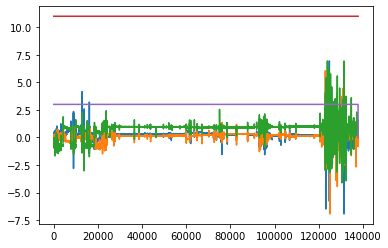

In [22]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:, i])

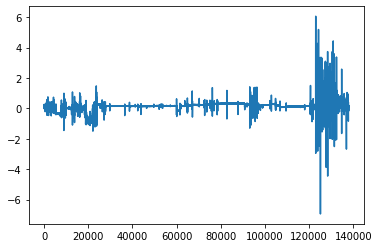

In [23]:
plt.plot(data[:,1])

## Plot Dataset Summary

In [24]:
# Count class representation

beh_names = dataset_metadata['label_names']
label_count = {fold : {name : 0 for name in beh_names} for fold in range(n_folds)}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        for fold in range(n_folds):
            if clip_id in dataset_metadata['clip_ids_per_fold'][fold]:
                label_count[fold][name] += counts[key]
                
label_perc = {fold : {name : 0 for name in beh_names[1:]} for fold in range(n_folds)}

for name in beh_names[1:]:
    for fold in range(n_folds):
        label_perc[fold][name] = float(label_count[fold][name] / sum([label_count[fold][j] for j in beh_names[1:]]))


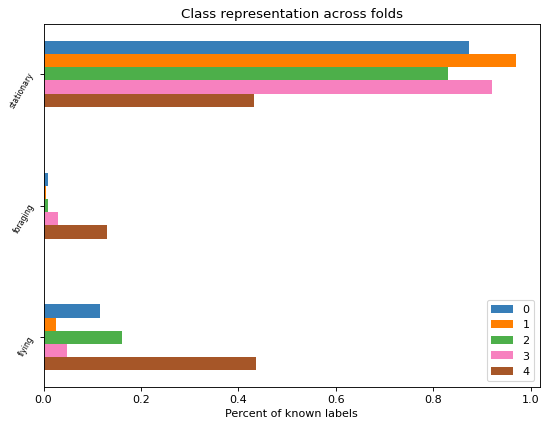

In [25]:
# Plot class representation

# https://gist.github.com/thriveth/8560036#file-cbcolors-py
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.1
plt.figure(figsize=(8, 6), dpi=80)

for fold in range(n_folds):
    current_offset = -(fold - n_folds // 2)*offset
    plt.barh(keys +current_offset, [label_perc[fold][beh_names[key]] for key in keys], height=width, align='center', label = fold, color = CB_color_cycle[fold])
    
plt.title("Class representation across folds")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.svg')

plt.savefig(target_fp, format = 'svg')
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
with open(numerical_target_fp, 'w') as file:
    yaml.dump(label_perc, file)

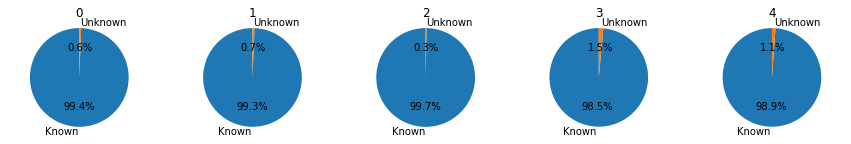

In [26]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
sizes = {fold : [sum([label_count[fold][j] for j in beh_names[1:]]), label_count[fold]['unknown']] for fold in range(n_folds)}
# train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
# val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
# test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,n_folds, figsize = (3*n_folds,2))

for fold in range(n_folds):
    ax[fold].pie(sizes[fold], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[fold].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[fold].set_title(fold)

target_fp = os.path.join(formatted_data_dir, 'perc_known.svg')

plt.savefig(target_fp, format='svg')

plt.show()


## Temporal Statistics

In [27]:
####################################
infill_max_dur_sec = 0 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if len(list_of_labels) > 0:
        if list_of_labels[-1] == unknown_value:
            del list_of_labels[-1]
            del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 22/22 [00:09<00:00,  2.42it/s]

Mean overall label duration is 2823.743 seconds
Re-saving metadata to /home/jupyter/behavior_data_local/data/formatted/maekawa_gulls/dataset_metadata.yaml
